# 13 - Difference-in-Differences

## Three Billboards in the South of Brazil

I remember when I worked with marketing and a great way to do it was with internet advertisement. Not because it is very efficient (although it is), but because it is very easy to know if it's effective or not. With online marketing, you have a way of knowing which customers saw the ad and you can track them with cookies to see if they ended up on your landing page or clicked some download button. You can also use machine learning to find prospects that are very similar to your customers and present the ad only to them. In this sense, online marketing is very precise: you target only those you want to and you can see if they respond as you would like them to. 

But not everyone is susceptible to online marketing. Sometimes you have to resort to less precise techniques, like a TV campaign or placing a billboard down the street. Usually, diversity of marketing channels is something marketing departments look for. But if online marketing is a professional fishing rod to catch that specific type of tuna, billboard and TV are giant nets you throw at a fish shoal and hope to catch at least some big ones. Another problem with billboard and TV ads is that it is much harder to know how effective they are. Sure, you could measure the purchase volume, or whatever you want to drive, before and after placing a billboard somewhere. If there is an increase, there is some evidence that the marketing is effective. But how would you know if this increase is not just some natural trend in the awareness of your product? In other words, how would you know the counterfactual $Y_0$ of what would have happened if you didn't set up the billboards in the first place? 

![img](./data/img/diff-in-diff/secrets.png)

One technique to answer these types of questions is Difference-in-Difference, or diff-in-diff for close friends. Diff-in-diff is commonly used to assess the effect of macro interventions, like the effect of immigration on unemployment, the effect of gun law changes in crime rates or simply the difference in user engagement due to a marketing campaign. In all these cases, you have a period before and after the intervention and you wish to untangle the impact of the intervention from a general trend. As a motivating example, let's look at a question similar to the one I had to answer.

In order to figure out how good billboards were as a marketing channel, we placed 3 billboards in the city of Porto Alegre, the capital of the state of Rio Grande do Sul. We wanted to see if that boosted deposits into our savings account. As a note for those not very familiar with Brazilian geography, Rio Grande do Sul is part of the south of the country, one of the most developed regions. 

Having this in mind, we decided to also look at data from another capital from the south, Florianopolis, the capital city of the state of Santa Catarina. The idea is that we could use Florianopolis as a control sample to estimate the counterfactual $Y_0$ when compared to Porto Alegre (by the way, this was not the true experiment, which is confidential, but the idea is very similar). We placed the billboard in Porto Alegre for the entire month of June. The data we have looks like this:

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


%matplotlib inline

style.use("fivethirtyeight")

In [5]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


In [8]:
data.poa.unique()

array([1, 0])

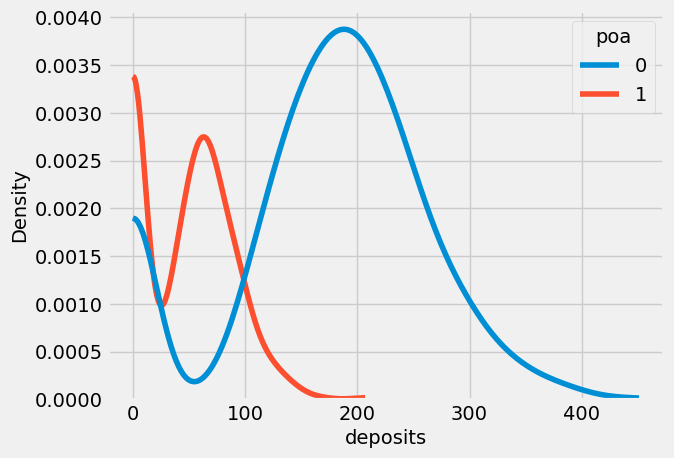

In [14]:
sns.kdeplot(data=data.query("jul == 0"), hue='poa', x='deposits', cut=0)
plt.show()

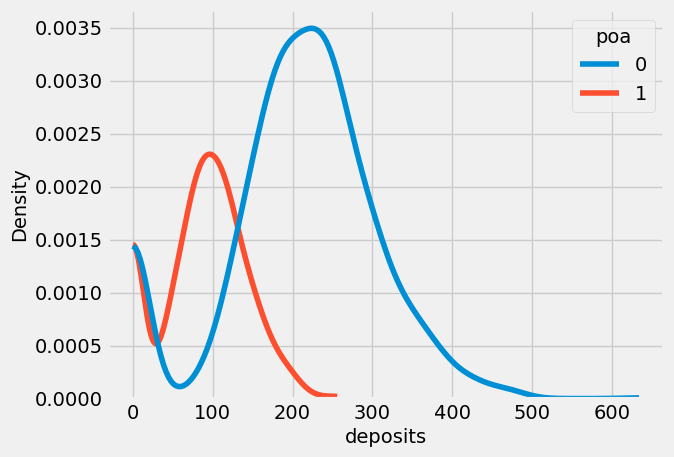

In [13]:
sns.kdeplot(data=data.query("jul == 1"), hue='poa', x='deposits', cut=0)
plt.show()

Remember that deposits are our outcome variable, the one we wish to increase with the billboards. POA is a dummy indicator for the city of Porto Alegre. When it is zero, it means the samples are from Florianopolis. Jul is a dummy for the month of July, or for the post intervention period. When it is zero it refers to samples from May, the pre-intervention period.

## DID Estimator

To avoid confusion between Time and Treatment, from now on, I'll use D to denote treatment and T to denote time. Let $Y_D(T)$ be the potential outcome for treatment D on period T. In an ideal world where we have the ability to observe the counterfactual, we would estimate the treatment effect of an intervention the following way:

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

In words, the causal effect is the outcome in the period post intervention in case of a treatment minus the outcome in also in the period after the intervention, but in the case of no treatment. Of course, we can't measure this because $Y_0(1)$ is counterfactual. 

One way around this is a before and after comparison.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

In our example, we would compare the average deposits from POA before and after the billboard was placed.

In [3]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

This estimator is telling us that we should expect deposits to increase R$ 41,04 after the intervention. But can we trust this?

Notice that $E[Y(0)|D=1]=E[Y_0(0)|D=1]$, that is, the observed outcome for the treated unit **before the intervention** is equal to the counterfactual outcome for the treated unit also before the intervention. Since we are using this to estimate the counterfactual **after the intervention**  $E[Y_0(1)|D=1]$, this estimation above assumes that $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$. 

It is saying that in the case of no intervention, the outcome in the latter period would be the same as the outcome from the starting period. This would obviously be false if your outcome variable follows any kind of trend. For example, if deposits are going up in POA, $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$, i.e. the outcome of the latter period would be greater than that of the starting period even in the absence of the intervention. With a similar argument, if the trend in Y is going down, $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$. This is to show that this before and after thing is not a great estimator. 

Another idea is to compare the treated group with an untreated group that didn't get the intervention:

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

In our example, it would be to compare the deposits from POA to that of Florianopolis in the post intervention period.

In [4]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

This estimator is telling us that the campaign is detrimental and that customers will decrease deposits by R$ 119.10. 

Notice that $E[Y(1)|D=0]=E[Y_0(1)|D=0]$. And since we are using $E[Y(1)|D=0]$ to estimate the counterfactual for the treated after the intervention, we are assuming we can replace the missing counterfactual like this: $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$. But notice that this would only be true if both groups have a very similar baseline level. For instance, if Florianopolis has way more deposits than Porto Alegre, this would not be true because $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$. On the other hand, if the level of deposits are lower in Florianopolis, we would have $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$. 

Again, this is not a great idea. To solve this, we can use both space and time comparison. This is the idea of the difference in difference approach. It works by replacing the missing counterfactual the following way:

$
E[Y_0(1)|D=1] = E[Y_0(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

What this does is take the treated unit **before the intervention** and adds a trend component to it, which is estimated using the control $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$. In words, it is saying that the treated **after the intervention**, had it not been treated, would look like the **treated before the treatment** plus a growth factor that is the same as the growth of the control. 

It is important to notice that this assumes that the trends in the treatment and control are the same:

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

where the left hand side is the counterfactual trend. Now, we can replace the estimated counterfactual in the treatment effect definition $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

If we rearrange the terms, we get the classical Diff-in-Diff estimator.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

It gets that name because it gets the difference between the difference between treatment and control after and before the treatment. 

Here is what that looks in code.

In [5]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

Diff-in-Diff is telling us that we should expect deposits to increase by R$ 6.52 per customer. Notice that the assumption that diff-in-diff makes is much more plausible than the other 2 estimators. It just assumes that the growth pattern between the 2 cities are the same. But it doesn't require them to have the same base level nor does it require the trend to be zero. 

To visualize what diff-in-diff is doing, we can project the growth trend from the untreated into the treated to see the counterfactual, that is, the number of deposits we should expect if there were no intervention.

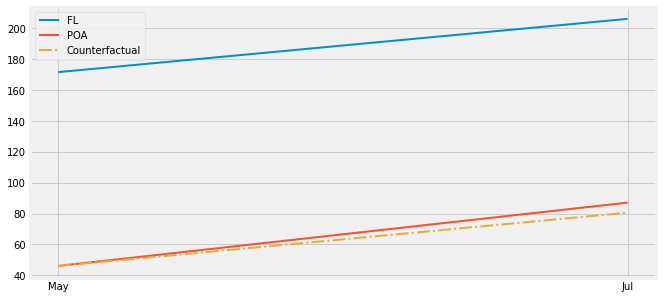

In [6]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

See that small difference between the red and the yellow dashed lines? If you really focus you can see the small treatment effect on Porto Alegre. 

![img](./data/img/diff-in-diff/cant-read.png)


Now, what you might be asking yourself is "how much can I trust this estimator? It is my right to have standard errors reported to me!". Which makes sense, since estimators without them look silly. To do so, we will use a neat trick that uses regression. Specifically, we will estimate the following linear model

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

Notice that $\beta_0$ is the baseline of the control. In our case, is the level of deposits in Florianopolis in the month of May. If we turn on the treated city dummy, we get $\beta_1$. So $\beta_0 + \beta_1$ is the baseline of Porto Alegre in May, before the intervention, and $\beta_1$ is the increase of Porto Alegre baseline on top of Florianopolis. If we turn the POA dummy off and turn the July dummy on, we get $\beta_0 + \beta_2$, which is the level of Florianópolis in July, after the intervention period. $\beta_2$ is then the trend of the control, since we add it on top of the baseline to get the level of the control at the period post intervention. As a recap, $\beta_1$ is the increment we get by going from the control to the treated, $\beta_2$ is the increment we get by going from the period before to the period after the intervention. Finally, if we turn both dummies on, we get $\beta_3$. $\beta_0 + \beta_1 + \beta_2 + \beta_3$ is the level in Porto Alegre after the intervention. So $\beta_3$ is the incremental impact when you go from May to July and from Florianopolis to POA. In other words, it is the Difference in Difference estimator. 

If you don't believe me, check for yourself. You should get the exact same number we got above. And also notice how we get our much wanted standard errors.

In [3]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Non Parallel Trends

One obvious problem with Diff-in-Diff is failure to satisfy the parallel trend assumption. If the growth trend from the treated is different from the trend of the control, diff-in-diff will be biased. This is a common problem with non-random data, where the decision to treat a region is based on its potential to respond well to the treatment, or when the treatment is targeted at regions that are not performing very well. Take our marketing example. We decided to test billboards in Porto Alegre not in order to check the effect of billboards in general. The reason is simply because sales perform poorly there. Perhaps online marketing is not working there. In this case, it could be that the growth we would see in Porto Alegre without a billboard would be lower than the growth we observe in other cities. This would cause us to underestimate the effect of the billboard there.

One way to check if this is happening is to plot the trend using past periods. For example, let's suppose POA had a small decreasing trend but Florianopolis was on a steep ascent. In this case, showing periods from before would reveal those trends and we would know Diff-in-Diff is not a reliable estimator.

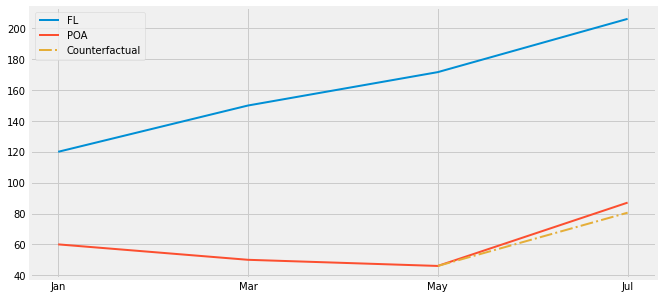

In [18]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

We will see how to solve this problem with synthetic control. It will use multiple cities to create a synthetic city that closely follows the trend of the city of interest. But for now, remember that you always need to check if you have parallel trends when applying diff-in-diff. 

![img](./data/img/diff-in-diff/non-parallel.png)

One final issue that it's worth mentioning is that you won't be able to place confidence intervals around your Diff-in-Diff estimator if you only have aggregated data. Say for instance you don't have data on what each of our customers from Florianópolis or Porto Alegre did. Instead, you only have the average deposits before and after the intervention for both cities. In this case, you will still be able to estimate the causal effect by Diff-in-Diff, but you won't know the variance of it. That's because all the variability in your data got squashed out in aggregation.

## Key Ideas

We've explored a technique widely applied when we are estimating causal effects at more macro entities (schools, cities, states, countries...). Difference in Difference takes a treated unit before and after the treatment and compares the trend in the outcome to that of a control unit. Here, we've seen how this could be applied at estimating the effect of a city specific marketing campaign.

Finally, we looked at how Diff-in-Diff fails if the trend between the treated and control unit is not the same. We also saw how diff-in-diff will be problematic if we only have aggregated data.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Other important reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Finally, I'd also like to compliment Scott Cunningham and his brilliant work mingling Causal Inference and Rap quotes:

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).